# **After call on 3/2**
**What I did in this notebook**
1. Used enhanced negative sampling
2. Fixed inconsistencies in PYVIS visualization
3. GNNExplainer runs for the predicted edges
4. Link prediction task between nodes that are either drugs or diseases



***Important note:***  
The code for **training the GCN model** and **explaining its predictions** using **GNNExplainer** is based on the official PyTorch Geometric example, which can be found [here](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/explain/gnn_explainer_link_pred.py).


# **Step 1: Install dependencies & import the necessary libraries**

In [1]:
#install the required dependencies for PyG
#https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html

!pip install torch_geometric
!pip install torch

!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu124.html
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
#import libraries
import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, average_precision_score


import networkx as nx
from pyvis.network import Network

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import ipywidgets as widgets
from IPython.display import display

# **Step 2: Load the graph in a Pandas df**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
#read the csv file (our graph) and load it in a Pandas df for preprocessing
graph = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/Knowledge Graph Sample.csv')

graph.head(5)

,ENTITY_A,ENTITY_A_CUI,RELATION,ENTITY_B,JOURNAL_B,ENTITY_B_CUI_OR_ARTICLE_id
0,ATXN3 gene,C1538301,PREVENTS,Toxic effect,NaN,C0600688
1,Extraction,C0185115,PREVENTS,Urinary tract infection,NaN,C0042029
2,polyglutamine,C0384782,PREVENTS,Toxic effect,NaN,C0600688
3,Therapeutic procedure,C0087111,PREVENTS,Teratogenesis,NaN,C0232910
4,Therapeutic procedure,C0087111,PREVENTS,Abnormal mental state,NaN,C0278061


# **Step 3: Encoding and mapping the data**
In this step, we need to make the knowledge graph data compatible with GNNs. To do so, we will prepare them by encoding all the nodes and relations into numeric values.

In [5]:
#find the unique nodes
unique_nodes = pd.Series(pd.concat([graph['ENTITY_A_CUI'], graph['ENTITY_B_CUI_OR_ARTICLE_id']]).unique())
#unique_nodes.head(5)
print(f"Unique nodes in the graph: {unique_nodes.nunique()}")

Unique nodes in the graph: 191


In [6]:
#nodes
#map each unique node to a unique numeric ID
node_id_mapping = {node: idx + 1 for idx, node in enumerate(unique_nodes)} #{'C1538301': 1, 'C0185115': 2...}

#adding columns ENTITY_A_ID , ENTITY_B_ID with the numeric IDs we created above
graph['ENTITY_A_ID'] = graph['ENTITY_A_CUI'].map(node_id_mapping)
graph['ENTITY_B_ID'] = graph['ENTITY_B_CUI_OR_ARTICLE_id'].map(node_id_mapping)

#relations
#map each relation to a unique numeric ID
relation_mapping = {relation: idx + 1 for idx, relation in enumerate(graph['RELATION'].unique())}

#adding the RELATION_ENCODED column with the encoded relation ID
graph['RELATION_ENCODED'] = graph['RELATION'].map(relation_mapping)

graph.head(5)

,ENTITY_A,ENTITY_A_CUI,RELATION,ENTITY_B,JOURNAL_B,ENTITY_B_CUI_OR_ARTICLE_id,ENTITY_A_ID,ENTITY_B_ID,RELATION_ENCODED
0,ATXN3 gene,C1538301,PREVENTS,Toxic effect,NaN,C0600688,1,34,1
1,Extraction,C0185115,PREVENTS,Urinary tract infection,NaN,C0042029,2,35,1
2,polyglutamine,C0384782,PREVENTS,Toxic effect,NaN,C0600688,3,34,1
3,Therapeutic procedure,C0087111,PREVENTS,Teratogenesis,NaN,C0232910,4,36,1
4,Therapeutic procedure,C0087111,PREVENTS,Abnormal mental state,NaN,C0278061,4,37,1


# **Step 4: Creating the nodes and edges files for PyTorch Geometric**
The next steps include training a GCN model and then applying GNNExplainer. To do so, we need the following files to construct the graph in PyG:


1. **nodes.csv**
   * Mapping of node IDs to their labels
  
2. **edges.csv**
   * The relations between nodes



In [7]:
#declaring the output directory for storing the csv files
output_dir = "/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/small_graph_files"
os.makedirs(output_dir, exist_ok=True)

#nodes.csv
#map node IDs with their node labels
node_label_mapping = dict(zip(graph['ENTITY_A_ID'], graph['ENTITY_A']))
node_label_mapping.update(dict(zip(graph['ENTITY_B_ID'], graph['ENTITY_B'])))

#dictionary to df, so that we can save it in csv format
node_label_df = pd.DataFrame(node_label_mapping.items(), columns=["Node_ID", "Node_Label"])
node_label_df.to_csv(os.path.join(output_dir, "nodes.csv"), index=False, sep=" ")

#edges.csv
#keep the columns i need for training the model and rename them for PyG
edges_df = graph[['ENTITY_A_ID', 'ENTITY_B_ID', 'RELATION_ENCODED']].rename(
    columns={'ENTITY_A_ID': 'Source', 'ENTITY_B_ID': 'Target', 'RELATION_ENCODED': 'Relation_Label'}
)
edges_df.to_csv(os.path.join(output_dir, "edges.csv"), index=False)

# **Step 5: Preparing the data for the GCN model and the GNNExplainer**  
This step consists of processing the data in a suitable format for PyG.

In [8]:
#use GPU (CUDA) if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load the nodes and edges files
nodes_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/small_graph_files/nodes.csv", sep=" ")
edges_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sykallou MSc Thesis/SMALL GRAPH/small_graph_files/edges.csv")

display(nodes_df)
display(edges_df)

,Node_ID,Node_Label
0,1,ATXN3 gene
1,2,Extraction
2,3,polyglutamine
3,4,Therapeutic procedure
4,5,Ophthalmic examination and evaluation
...,...,...
186,187,Mitochondrial mutation
187,188,"Adolescents, Female"
188,189,Neuroradiologist
189,190,Canis familiaris


,Source,Target,Relation_Label
0,1,34,1
1,2,35,1
2,3,34,1
3,4,36,1
4,4,37,1
...,...,...,...
288,29,44,10
289,30,44,10
290,31,44,10
291,32,52,10


In [9]:
#node mapping

#find all the unique node IDs from edges_df
unique_nodes = sorted(set(edges_df["Source"]).union(set(edges_df["Target"])))

#new method to resolve error: PyG requires continuous node indices
#mapping to have a sequential index to each unique node ID
node_mapping_fixed = {node_id: idx for idx, node_id in enumerate(nodes_df["Node_ID"].unique())}

#add Mapped_ID in the nodes df with the new sequential IDs
nodes_df["Mapped_ID"] = nodes_df["Node_ID"].map(node_mapping_fixed)

#apply new mapping logic
edges_df["Source"] = edges_df["Source"].map(node_mapping_fixed)
edges_df["Target"] = edges_df["Target"].map(node_mapping_fixed)

edges_df.head()

,Source,Target,Relation_Label
0,0,33,1
1,1,34,1
2,2,33,1
3,3,35,1
4,3,36,1


In [10]:
#mapping of relation labels - it's a reverse mapping (id -> relation) to help with visualizations
relation_label_mapping = {idx+1: relation for idx, relation in enumerate(graph['RELATION'].unique())}

In [11]:
#node embeddings - each node will have a 128 dim embedding vector
num_nodes = len(unique_nodes)

#number of features per node
embedding_dim = 128
#embedding layer for nodes
node_embeddings = torch.nn.Embedding(num_nodes, embedding_dim)

#embeddings weights
# x is the node feature matrix we will use in our GCN model
x = node_embeddings.weight

#PyTorch tensors will be used in order to create the PyG data object
#edges
edge_index = torch.tensor(edges_df[['Source', 'Target']].values.T, dtype=torch.long)
#indicate that every edge in the dataset is a positive edge
edges_df['Label'] = 1

#edge labels
edge_labels = torch.tensor(edges_df['Label'].values, dtype=torch.long)

#PyTorch Geometric data object
#in this variable we store the graph in a PyG format
data = Data(x=x, edge_index=edge_index, edge_label=edge_labels).to(device)

In [12]:
#splitting data in training, validation and testing sets
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.2,
    is_undirected=True,
    add_negative_train_samples=True #to generate false edges during training
)

#apply the transformation to the data obj
train_data, val_data, test_data = transform(data)

print(f"train_data: {train_data}")
print(f"val_data: {val_data}")
print(f"test_data: {test_data}")

train_data: Data(x=[191, 128], edge_index=[2, 412], edge_label=[412], edge_label_index=[2, 412])
val_data: Data(x=[191, 128], edge_index=[2, 412], edge_label=[58], edge_label_index=[2, 58])
test_data: Data(x=[191, 128], edge_index=[2, 470], edge_label=[116], edge_label_index=[2, 116])


In [13]:
#lables are converted to binary values
#.long() ensures that the labels are in int format as required for PyTorch loss function
train_data.edge_label = (train_data.edge_label > 0).long()
val_data.edge_label = (val_data.edge_label > 0).long()
test_data.edge_label = (test_data.edge_label > 0).long()

In [14]:
#generate random edges (non-existent) as negative samples to train the model
def generate_negative_edges(edge_index, num_nodes, num_neg_samples):
    #store edges and convert to a set to loop easier
    neg_edges = set()
    existing_edges = set(map(tuple, edge_index.T.cpu().numpy()))

    while len(neg_edges) < num_neg_samples:
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)
        #nodes do not exist in the graph && source / target nodes are different
        if src != dst and (src, dst) not in existing_edges and (dst, src) not in existing_edges:
            neg_edges.add((src, dst))
    return torch.tensor(list(neg_edges)).T.to(device)

#use as many negative samples as the positive ones
train_neg_edge_index = generate_negative_edges(train_data.edge_index, num_nodes, train_data.edge_index.size(1))

#combine positive and negative edges in one tensor
train_combined_edge_index = torch.cat([train_data.edge_index, train_neg_edge_index], dim=1)

train_combined_edge_labels = torch.cat([
    torch.ones(train_data.edge_index.size(1), dtype=torch.float).to(device), #positive edges = 1
    torch.zeros(train_neg_edge_index.size(1), dtype=torch.float).to(device), #negative edges = 0
])

# **Step 6: Definitions and initializations**

1. A Graph Convolutional Network (GCN) is defined with two layers
2. The GCN model, the Optimizer and the Loss function are initialized
3. The Training and Evaluation functions are defined
4. Negative edges are generated

In [15]:
#defining the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): #initialize the model with two layers
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index): #pass node features through the layers with the ReLU activation function
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index): #perform dot product on node embeddings to predict if a link or not
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index): #call encode() and decode() to generate predictions
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index).view(-1)


In [16]:
#initialize the GCN with 128 hidden dimensions and 64 output dimensions
model = GCN(data.num_node_features, 128, 64).to(device)

#use Adam optimizer with learning rate 0.01
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

#use binary cross-entropy loss with logits
loss_fn = torch.nn.BCEWithLogitsLoss()

In [17]:
#training function
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index) #node embeddings
    out = model.decode(z, train_combined_edge_index).view(-1) #decodes edge predictions
    loss = loss_fn(out, train_combined_edge_labels) #compute the binary cross-entropy loss
    loss.backward() #gradent descent (backpropagation)
    optimizer.step()
    return float(loss)

In [18]:
#compute the AUC score for evaluating the model
@torch.no_grad()
def evaluate(data, edge_index, edge_labels):
    model.eval()
    z = model.encode(data.x, data.edge_index) #compute node embeddings
    out = model.decode(z, edge_index).sigmoid()  #compute link prediction scores

    #this is to make sure that the labels are binary and the predictions a probabilities
    y_true = edge_labels.cpu().numpy() #ground truth labels
    y_score = out.cpu().numpy() #model predicted probs

    assert set(y_true).issubset({0, 1}), "labels must be 0 or 1"
    assert (y_score >= 0).all() and (y_score <= 1).all(), "predictions must be probabilities"

    return roc_auc_score(y_true, y_score)

# **Step 7: Training the model**

In [19]:
#training loop
#runs for 200 epochs
#every 20 epochs, we evaluate the Validation AUC and Test AUC
for epoch in range(1, 201):
    loss = train(train_data)
    if epoch % 20 == 0:
        val_auc = evaluate(val_data, val_data.edge_label_index, val_data.edge_label)
        test_auc = evaluate(test_data, test_data.edge_label_index, test_data.edge_label)
        print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}")


Epoch: 20, Loss: 0.1317, Val AUC: 0.5089, Test AUC: 0.6428
Epoch: 40, Loss: 0.0295, Val AUC: 0.4620, Test AUC: 0.5716
Epoch: 60, Loss: 0.0078, Val AUC: 0.3977, Test AUC: 0.5565
Epoch: 80, Loss: 0.0026, Val AUC: 0.3817, Test AUC: 0.5455
Epoch: 100, Loss: 0.0011, Val AUC: 0.3811, Test AUC: 0.5413
Epoch: 120, Loss: 0.0006, Val AUC: 0.3757, Test AUC: 0.5395
Epoch: 140, Loss: 0.0004, Val AUC: 0.3746, Test AUC: 0.5333
Epoch: 160, Loss: 0.0003, Val AUC: 0.3769, Test AUC: 0.5326
Epoch: 180, Loss: 0.0002, Val AUC: 0.3746, Test AUC: 0.5323
Epoch: 200, Loss: 0.0002, Val AUC: 0.3686, Test AUC: 0.5288


# **Step 8: Providing explanations using GNNExplainer**
Providing explanations for a **specific edge**.

In [20]:
#the model's explanation configurations
model_config = ModelConfig(
    mode='binary_classification', #because we perform a link prediction task
    task_level='edge', #the explanations are focused on edges (link prediction task)
    return_type='raw',
)

#initializing GNNExplainer
explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes', #explains which node attributes are important for the predictions
    edge_mask_type='object', #explains which edges important for the predictions
    model_config=model_config,
)

#explain a specific edge
#GNNExplainer is applied to identidy important nodes and edges leading to the prediction
edge_index_to_explain = 12  #the ith +1 edge
edge_label_index = val_data.edge_label_index[:, edge_index_to_explain]

explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_label_index=edge_label_index,
)
print(f"Explanations available: {explanation.available_explanations}")
#output of available_explanations: ['edge_mask', 'node_mask']
#this means that the explainer was able to identify the important edge and node features for the link prediction task

Explanations available: ['node_mask', 'edge_mask']


# **Step 9: Visualizing/Understanding Explanations**

In [21]:
#find the top 10 influential edges for the link prediction task

#extract edge mask to see which edges are most important
edge_mask = explanation.edge_mask.cpu().detach().numpy()
top_edges_indices = np.argsort(edge_mask)[-10:].copy()

#edge pairs
top_edges = train_data.edge_index[:, top_edges_indices].cpu().numpy().T

print("Top 10 Most Important Edges:")
for i, (src, dst) in enumerate(top_edges):
    print(f"{i+1}. Edge ({src} → {dst}), Importance Score: {edge_mask[top_edges_indices[i]]:.4f}")

Top 10 Most Important Edges:
1. Edge (15 → 47), Importance Score: 0.0796
2. Edge (20 → 56), Importance Score: 0.0796
3. Edge (20 → 97), Importance Score: 0.0796
4. Edge (19 → 47), Importance Score: 0.0798
5. Edge (175 → 21), Importance Score: 0.0822
6. Edge (179 → 21), Importance Score: 0.0830
7. Edge (174 → 21), Importance Score: 0.0871
8. Edge (178 → 21), Importance Score: 0.0904
9. Edge (21 → 97), Importance Score: 0.9350
10. Edge (16 → 47), Importance Score: 0.9354


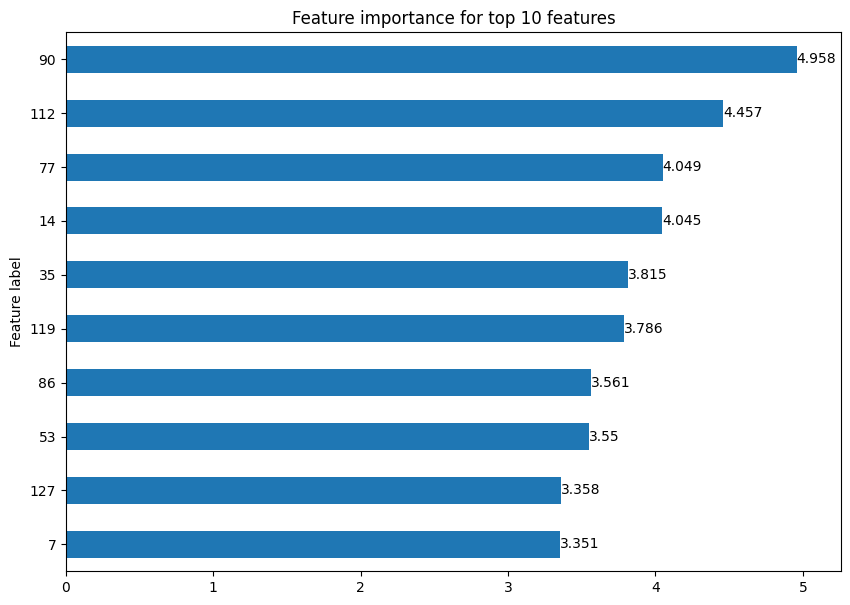

In [22]:
#Viz 1: Feature importance (the top 10 attributes (nodes))
explanation.visualize_feature_importance(top_k=10)

#PDF Viz: An explainability graph, where the key nodes and edges are highlighted
explanation.visualize_graph()

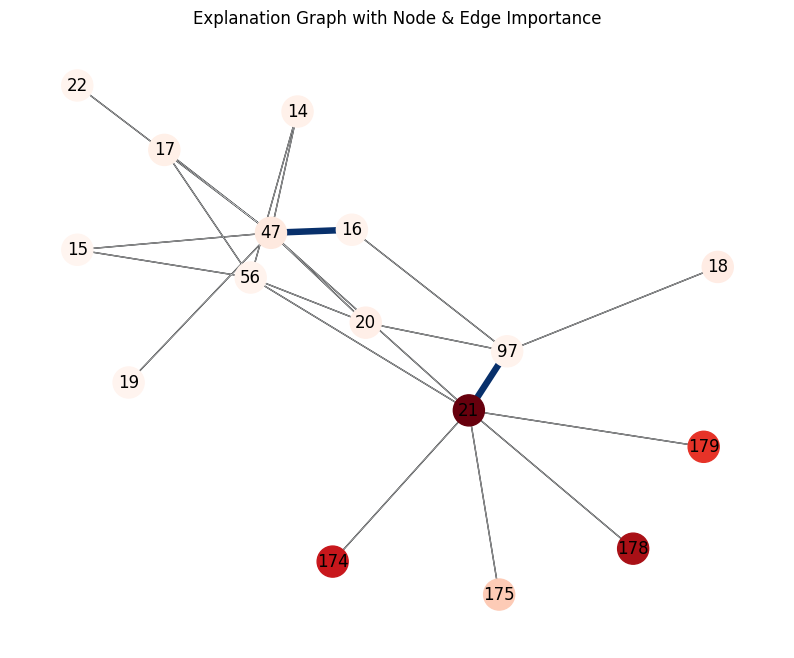

In [23]:
#Viz 2: Visualization of the graph with node and edge importance
#nodes: colored based on importance (node_mask)
#edges: thicker based on importance (edge_mask)

original_edges_set = set(map(tuple, edges_df[['Source', 'Target']].values))

G = nx.Graph()

#EDGE IMPORTANCE
edges = train_data.edge_index.cpu().numpy().T
edge_mask = explanation.edge_mask.cpu().detach().numpy()

#loop through all edges and only add important edges (edge_mask > 0)
for i, (src, dst) in enumerate(edges):
    if edge_mask[i] > 0 and (src, dst) in original_edges_set:
      G.add_edge(src, dst, weight=edge_mask[i])

#NODE IMPORTANCE
#for each node, sum importance across all feature dims
node_mask = explanation.node_mask.cpu().detach().numpy().sum(axis=1)
#dict to map the node indices with their importance score
node_importance = {i: node_mask[i] for i in range(len(node_mask))}

pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(figsize=(10, 8))

#draw nodes with importance-based color
node_colors = [node_importance.get(node, 0) for node in G.nodes()]
nx.draw(
    G, pos, with_labels=True, node_size=500, cmap=plt.cm.Reds, node_color=node_colors, ax=ax
)

#draw edges with importance-based width
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
edge_collection = nx.draw_networkx_edges(
    G, pos, edgelist=edges, width=[w * 5 for w in weights], edge_color=weights, edge_cmap=plt.cm.Blues, ax=ax
)

plt.title("Explanation Graph with Node & Edge Importance")
plt.show()


In [24]:
#Viz 3 - INTERACTIVE: Visualization of the graph with node/edge importance and node/edge labels

def visualize_graph(top_n_nodes=20):
    G = nx.Graph()

    #original edges
    original_edges_set = set(map(tuple, edges_df[['Source', 'Target']].values))

    #mapping edges to relations
    edge_relation_mapping = {}
    for idx, row in edges_df.iterrows():
        src_val = int(row['Source'])
        dst_val = int(row['Target'])
        relation_id = row['Relation_Label']

        relation_text = relation_label_mapping.get(relation_id, f"Relation {relation_id}")
        #the graph is undirected
        edge_relation_mapping[(src_val, dst_val)] = relation_text
        edge_relation_mapping[(dst_val, src_val)] = relation_text

    #get model's predicted edges and explanations
    edges = train_data.edge_index.cpu().numpy().T
    edge_mask = explanation.edge_mask.cpu().detach().numpy()

    #get node importance
    node_importance_array = explanation.node_mask.cpu().detach().numpy().sum(axis=1)
    node_importance = {node: node_importance_array[node] for node in set(edges_df[['Source', 'Target']].values.flatten())}

    #top n nodes
    sorted_nodes = sorted(node_importance.keys(), key=lambda n: node_importance[n], reverse=True)
    important_nodes = sorted_nodes[:top_n_nodes]

    #edge labels
    #add only positive edges and their labels
    edge_labels = {}
    for i, (src, dst) in enumerate(edges):
        if (src, dst) in original_edges_set or (dst, src) in original_edges_set:
            if src in important_nodes and dst in important_nodes:
                G.add_edge(int(src), int(dst), weight=edge_mask[i])

                relation_text = edge_relation_mapping.get((int(src), int(dst)), "Relation None")
                edge_labels[(int(src), int(dst))] = relation_text

    #error handling when there are no edges after using the slider
    if len(G.edges) == 0:
        print("There are no available edges for this number of nodes")
        return

    #node labels
    node_labels = {}
    for node in G.nodes():
        #convert PyG node index back to the original dataset ID
        if node in node_mapping_fixed.values():
            original_id = list(node_mapping_fixed.keys())[list(node_mapping_fixed.values()).index(node)]
        else:
            original_id = None

        if original_id is not None:
            label = node_label_mapping.get(original_id, str(original_id))
            node_labels[node] = label if not pd.isna(label) else str(original_id)
        else:
            node_labels[node] = str(node) #show the node


    pos = nx.spring_layout(G, seed=42)
    fig, ax = plt.subplots(figsize=(12, 8))


    node_colors = [node_importance.get(node, 0) for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True, labels=node_labels, node_size=800, cmap=plt.cm.Reds,
        node_color=node_colors, font_size=10, font_weight='bold', ax=ax
    )

    if len(G.edges) > 0:
        edges_draw, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw_networkx_edges(
            G, pos, edgelist=edges_draw, width=[w * 5 for w in weights],
            edge_color=weights, edge_cmap=plt.cm.Blues, ax=ax, alpha=0.7
        )
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax, font_weight='bold')

    plt.title("Filtered Explanation Graph with Node/Edge Importance and Labels", fontsize=14)
    plt.show()

#slider to select the wanted number of nodes
node_slider = widgets.IntSlider(value=20, min=5, max=100, step=5, description='Top N nodes')
widgets.interactive(visualize_graph, top_n_nodes=node_slider)


interactive(children=(IntSlider(value=20, description='Top N nodes', min=5, step=5), Output()), _dom_classes=(…

In [25]:
#Viz 4 - PyVis visualization of the graph with node/edge importance and node/edge labels

def visualize_graph_pyvis(top_n_nodes=20, output_file="pyvis_graph.html"):
    original_edges_set = set(map(tuple, edges_df[['Source', 'Target']].values))
    edge_relation_mapping = {}
    for idx, row in edges_df.iterrows():
        src_val = int(row['Source'])
        dst_val = int(row['Target'])
        relation_id = row['Relation_Label']
        relation_text = relation_label_mapping.get(relation_id, f"Relation {relation_id}")
        #undirected graph
        edge_relation_mapping[(src_val, dst_val)] = relation_text
        edge_relation_mapping[(dst_val, src_val)] = relation_text

    #get predicted edges and their importance (edge mask)
    predicted_edges = train_data.edge_index.cpu().numpy().T
    edge_mask = explanation.edge_mask.cpu().detach().numpy()

    #node importance
    node_importance_array = explanation.node_mask.cpu().detach().numpy().sum(axis=1)

    dataset_nodes = set(edges_df[['Source', 'Target']].values.flatten())
    node_importance = {node: node_importance_array[node]
                       for node in dataset_nodes if node < len(node_importance_array)}

    #get top N important nodes from the dataset
    sorted_nodes = sorted(node_importance.keys(), key=lambda n: node_importance[n], reverse=True)
    important_nodes = sorted_nodes[:top_n_nodes]

    #edges that are in the original dataset
    edge_list = []
    nodes_in_graph = set()
    for i, (src, dst) in enumerate(predicted_edges):
        if (src, dst) in original_edges_set or (dst, src) in original_edges_set:
            if src in important_nodes and dst in important_nodes:
                weight = float(edge_mask[i])
                relation_text = edge_relation_mapping.get((int(src), int(dst)), "Relation None")
                edge_list.append((int(src), int(dst), weight, relation_text))
                nodes_in_graph.add(int(src))
                nodes_in_graph.add(int(dst))

    if len(nodes_in_graph) == 0:
        print("There are no available edges for this number of nodes")
        return

    #convert PyG node index to the original dataset ID
    node_labels = {}
    for node in nodes_in_graph:
        if node in node_mapping_fixed.values():
            original_id = list(node_mapping_fixed.keys())[list(node_mapping_fixed.values()).index(node)]
        else:
            original_id = None
        if original_id is not None:
            label = node_label_mapping.get(original_id, str(original_id))
            node_labels[node] = label if not pd.isna(label) else str(original_id)
        else:
            node_labels[node] = str(node)

    #nodes in reds
    node_vals = [node_importance.get(n, 0) for n in nodes_in_graph]
    min_node_val, max_node_val = min(node_vals), max(node_vals)
    node_norm = mcolors.Normalize(vmin=min_node_val, vmax=max_node_val)
    reds = plt.cm.Reds

    #edges in blues
    edge_weights = [w for (_, _, w, _) in edge_list]
    min_edge_val, max_edge_val = min(edge_weights), max(edge_weights)
    edge_norm = mcolors.Normalize(vmin=min_edge_val, vmax=max_edge_val)
    blues = plt.cm.Blues

    #PyVis network
    net = Network(
        height="100vh",
        width="100vw",
        bgcolor="white",
        font_color="black",
        cdn_resources="remote")

    net.barnes_hut(
        gravity=-5000,
        central_gravity=0.1,
        spring_length=250,
        spring_strength=0.008,
        damping=0.09,
        overlap=0.5
    )

    for node in nodes_in_graph:
        label = node_labels[node]
        imp = node_importance.get(node, min_node_val)
        node_color = mcolors.to_hex(reds(node_norm(imp)))
        net.add_node(node, label=label, title=label, size=50, color=node_color,
                     font={"size": 18, "color": "black", "bold": True})


    min_threshold = 0.3
    for (src, dst, weight, relation_text) in edge_list:
        norm_value = edge_norm(weight)
        norm_value = max(norm_value, min_threshold)
        edge_color = mcolors.to_hex(blues(norm_value))
        net.add_edge(src, dst, value=weight, width=weight * 5, color=edge_color,
                     title=relation_text, label=relation_text,
                     font={"size": 18, "color": "black", "bold": True})

    #save the PyVis graph in an HTML file
    net.save_graph(output_file)
    print(f"The graph is saved here: {output_file}")

visualize_graph_pyvis(top_n_nodes=10)

The graph is saved here: pyvis_graph.html


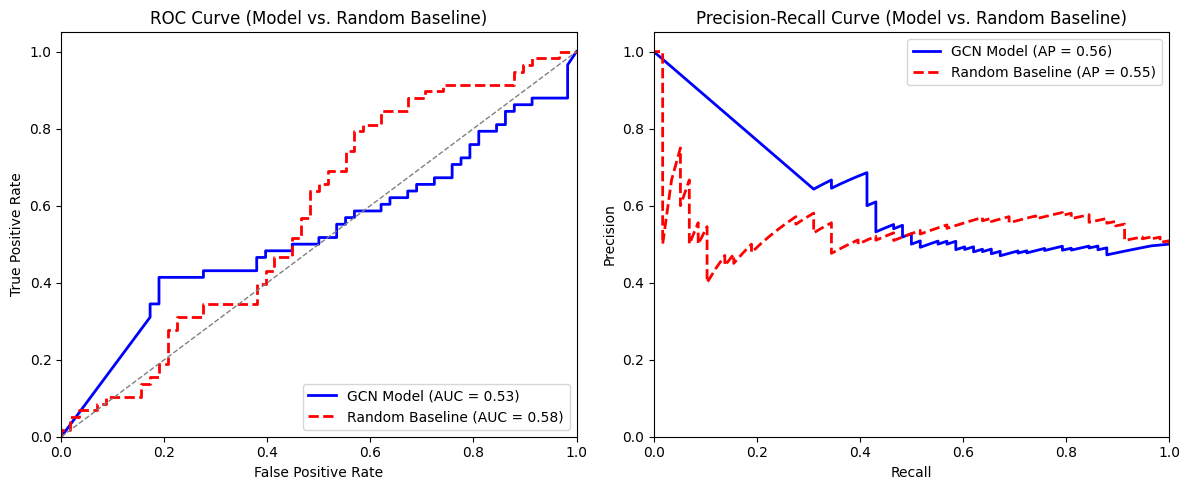

In [26]:
#Vis 5: ROC, Precision-Recall curve and baseline comparison with a random edge predictor, to evaluate the performance of the GCN model

#true labels and predicted probs
test_true = test_data.edge_label.cpu().numpy()
test_pred = model.decode(model.encode(test_data.x, test_data.edge_index),
                         test_data.edge_label_index).sigmoid().cpu().detach().numpy()

#ROC curve
fpr, tpr, _ = roc_curve(test_true, test_pred)
roc_auc = auc(fpr, tpr)

#PR curve
precision, recall, _ = precision_recall_curve(test_true, test_pred)
average_precision = average_precision_score(test_true, test_pred)

#generate random baseline predictions
random_preds = np.random.rand(len(test_true))
fpr_random, tpr_random, _ = roc_curve(test_true, random_preds)
roc_auc_random = auc(fpr_random, tpr_random)

precision_random, recall_random, _ = precision_recall_curve(test_true, random_preds)
average_precision_random = average_precision_score(test_true, random_preds)

#AUC-ROC Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'GCN Model (AUC = {roc_auc:.2f})')
plt.plot(fpr_random, tpr_random, color='red', linestyle='--', lw=2, label=f'Random Baseline (AUC = {roc_auc_random:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Model vs. Random Baseline)')
plt.legend(loc="lower right")

#Precision-Recall (PR) Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'GCN Model (AP = {average_precision:.2f})')
plt.plot(recall_random, precision_random, color='red', linestyle='--', lw=2, label=f'Random Baseline (AP = {average_precision_random:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Model vs. Random Baseline)')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


# **Step 10: Run GNNExplainer on predicted links**

In [27]:
#find the predicted edges

model.eval() #set to eval mode

with torch.no_grad():
    z = model.encode(test_data.x, test_data.edge_index)
    test_scores = model.decode(z, test_data.edge_label_index).sigmoid()

threshold = 0.5 #the default threshold for binary classification
#and only keep edges with pred score > threshold
predicted_edges = test_data.edge_label_index[:, test_scores > threshold]

print(f"Number of predicted edges: {predicted_edges.size(1)}")
print("The predicted edges (source and target indices):")
print(predicted_edges)

Number of predicted edges: 61
The predicted edges (source and target indices):
tensor([[ 15,   3,  16,  22,  22,  15,  14,  16,  18,  15,   6,  15,  15,  16,
          19,  20,  15,  25,  26,  14,  16,  15,  22,  16,  16,  16,  18,  16,
          14,  28,  55,   3,  71,  45, 184, 124,  95, 156,  79,  96,  99, 125,
         155, 142,  10,  74, 136,  80,  22, 112,  69,  61, 125,   0,  70, 111,
          33, 121,  94, 168,  13],
        [ 79,  37,  90, 184, 188,  56,  56, 102, 127,  77,  42,  76,  83, 106,
         144, 160,  59,  43,  43,  59, 107,  76, 127,  47,  89,  96, 133,  84,
          61,  43, 105,  25, 159,  12, 185, 176,  93, 107,  23,  35, 155,  32,
          80,  95, 161,  71,  21,  35,  76,  66, 156, 176, 114,  60, 140, 138,
         128,  86,   7, 185,  92]])


In [28]:
#run the explainer to get explanations of a specific edge from the set of pred links we found above
if predicted_edges.size(1) > 0:
    edge_index_to_explain = 17  #(+1) finds the 18th edge index, not edge with id 18
    edge_to_explain = predicted_edges[:, edge_index_to_explain]

    #run GNNExplainer on the selected pred edge
    explanation = explainer(
        x=test_data.x,
        edge_index=test_data.edge_index,
        edge_label_index=edge_to_explain.unsqueeze(1),
    )

    print("Explanation available:")
    print(explanation.available_explanations)
else:
    print("No predicted edges found")

Explanation available:
['node_mask', 'edge_mask']


In [29]:
#find top 10 most important edges
edge_mask = explanation.edge_mask.cpu().detach().numpy()

#get the indices of the top 10 edges with the highest importance scores
top_edges_indices = np.argsort(edge_mask)[-10:].copy()

#edge_index from test_data
top_edges = test_data.edge_index[:, top_edges_indices].cpu().numpy().T

print("Top 10 most important edges:")
for i, (src, dst) in enumerate(top_edges):
    print(f"{i+1}. Edge ({src} → {dst}), Importance Score: {edge_mask[top_edges_indices[i]]:.4f}")


Top 10 most important edges:
1. Edge (24 → 43), Importance Score: 0.1148
2. Edge (95 → 22), Importance Score: 0.1149
3. Edge (103 → 16), Importance Score: 0.1153
4. Edge (51 → 22), Importance Score: 0.1163
5. Edge (121 → 17), Importance Score: 0.1167
6. Edge (12 → 43), Importance Score: 0.1175
7. Edge (11 → 43), Importance Score: 0.1181
8. Edge (13 → 43), Importance Score: 0.1186
9. Edge (9 → 43), Importance Score: 0.1227
10. Edge (27 → 43), Importance Score: 0.1257


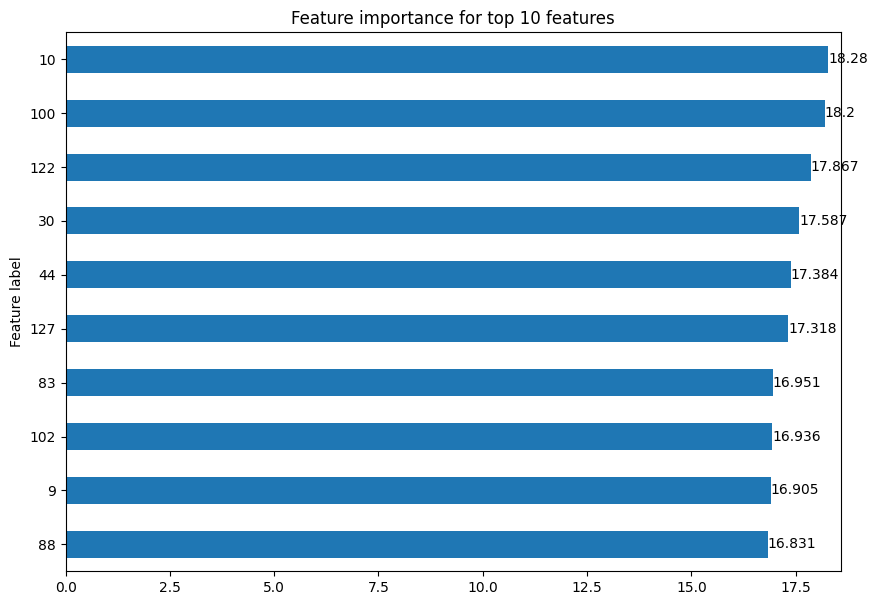

In [30]:
#Viz 1: Feature importance (the top 10 attributes (nodes))
explanation.visualize_feature_importance(top_k=10)

#PDF Viz: An explainability graph, where the key nodes and edges are highlighted
explanation.visualize_graph()

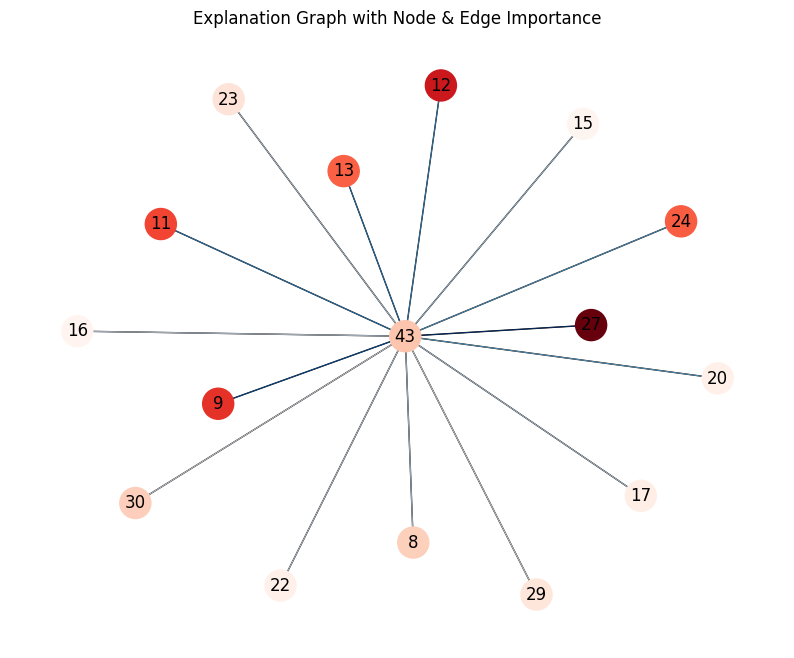

In [31]:
# Viz 2: Visualization of the graph with node and edge importance
#nodes: colored based on importance (node_mask)
#edges: thicker based on importance (edge_mask)

original_edges_set = set(map(tuple, edges_df[['Source', 'Target']].values))
G = nx.Graph()

#EDGE IMPORTANCE
edges = test_data.edge_index.cpu().numpy().T
edge_mask = explanation.edge_mask.cpu().detach().numpy()

#loop through all edges and only add important edges (edge_mask > 0)
for i, (src, dst) in enumerate(edges):
    if edge_mask[i] > 0 and (src, dst) in original_edges_set:
        G.add_edge(src, dst, weight=edge_mask[i])

#NODE IMPORTANCE
#for each node, sum importance across all feature dims
node_mask = explanation.node_mask.cpu().detach().numpy().sum(axis=1)
#dict to map the node indices with their importance score
node_importance = {i: node_mask[i] for i in range(len(node_mask))}

pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(figsize=(10, 8))

#draw nodes with importance-based color
node_colors = [node_importance.get(node, 0) for node in G.nodes()]
nx.draw(
    G, pos, with_labels=True, node_size=500, cmap=plt.cm.Reds,
    node_color=node_colors, ax=ax
)

#draw edges with importance-based width
edges_list, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw_networkx_edges(
    G, pos, edgelist=edges_list,
    width=[w * 5 for w in weights],
    edge_color=weights, edge_cmap=plt.cm.Blues, ax=ax
)

plt.title("Explanation Graph with Node & Edge Importance")
plt.show()


In [32]:
# Viz 3 - INTERACTIVE: Visualization of the graph with node/edge importance and node/edge labels
def visualize_graph(top_n_nodes=20):
    G = nx.Graph()

    #original edges
    original_edges_set = set(map(tuple, edges_df[['Source', 'Target']].values))

    #mapping edges to relations
    edge_relation_mapping = {}
    for idx, row in edges_df.iterrows():
        src_val = int(row['Source'])
        dst_val = int(row['Target'])
        relation_id = row['Relation_Label']

        relation_text = relation_label_mapping.get(relation_id, f"Relation {relation_id}")
        #the graph is undirected
        edge_relation_mapping[(src_val, dst_val)] = relation_text
        edge_relation_mapping[(dst_val, src_val)] = relation_text

    #get model's predicted edges and explanations
    edges = test_data.edge_index.cpu().numpy().T
    edge_mask = explanation.edge_mask.cpu().detach().numpy()

    #get node importance
    node_importance_array = explanation.node_mask.cpu().detach().numpy().sum(axis=1)

    # Step 4: Map node importance to dataset nodes based on the original CSV.
    node_importance = {node: node_importance_array[node]
                       for node in set(edges_df[['Source', 'Target']].values.flatten())}

    #top n nodes
    sorted_nodes = sorted(node_importance.keys(), key=lambda n: node_importance[n], reverse=True)
    important_nodes = sorted_nodes[:top_n_nodes]

    #edge labels
    #add only positive edges and their labels
    edge_labels = {}
    for i, (src, dst) in enumerate(edges):
        if (src, dst) in original_edges_set or (dst, src) in original_edges_set:
            if src in important_nodes and dst in important_nodes:
                G.add_edge(int(src), int(dst), weight=edge_mask[i])

                relation_text = edge_relation_mapping.get((int(src), int(dst)), "Relation None")
                edge_labels[(int(src), int(dst))] = relation_text

    #error handling when there are no edges after using the slider
    if len(G.edges) == 0:
        print("There are no available edges for this number of nodes")
        return

    #node labels
    node_labels = {}
    for node in G.nodes():
        #convert PyG node index back to the original dataset ID
        if node in node_mapping_fixed.values():
            original_id = list(node_mapping_fixed.keys())[list(node_mapping_fixed.values()).index(node)]
        else:
            original_id = None

        if original_id is not None:
            label = node_label_mapping.get(original_id, str(original_id))
            node_labels[node] = label if not pd.isna(label) else str(original_id)
        else:
            node_labels[node] = str(node)  #show the node

    pos = nx.spring_layout(G, seed=42)
    fig, ax = plt.subplots(figsize=(12, 8))

    node_colors = [node_importance.get(node, 0) for node in G.nodes()]
    nx.draw(
        G, pos, with_labels=True, labels=node_labels, node_size=800, cmap=plt.cm.Reds,
        node_color=node_colors, font_size=10, font_weight='bold', ax=ax
    )

    if len(G.edges) > 0:
        edges_draw, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw_networkx_edges(
            G, pos, edgelist=edges_draw, width=[w * 5 for w in weights],
            edge_color=weights, edge_cmap=plt.cm.Blues, ax=ax, alpha=0.7
        )
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax, font_weight='bold')

    plt.title("Filtered Explanation Graph with Node/Edge Importance and Labels", fontsize=14)
    plt.show()

#slider to select the wanted number of nodes
node_slider = widgets.IntSlider(value=20, min=5, max=100, step=5, description='Top N Nodes')
widgets.interactive(visualize_graph, top_n_nodes=node_slider)


interactive(children=(IntSlider(value=20, description='Top N Nodes', min=5, step=5), Output()), _dom_classes=(…

In [33]:
#Viz 4 - PyVis visualization of the graph with node/edge importance and node/edge labels
def visualize_graph_pyvis(top_n_nodes=20, output_file="pyvis_graph_predicted_links.html"):
    original_edges_set = set(map(tuple, edges_df[['Source', 'Target']].values))
    edge_relation_mapping = {}
    for idx, row in edges_df.iterrows():
        src_val = int(row['Source'])
        dst_val = int(row['Target'])
        relation_id = row['Relation_Label']
        relation_text = relation_label_mapping.get(relation_id, f"Relation {relation_id}")
        #undirected graph
        edge_relation_mapping[(src_val, dst_val)] = relation_text
        edge_relation_mapping[(dst_val, src_val)] = relation_text

    #get predicted edges and their importance (edge mask)
    predicted_edges = test_data.edge_index.cpu().numpy().T
    edge_mask = explanation.edge_mask.cpu().detach().numpy()

    #node importance
    node_importance_array = explanation.node_mask.cpu().detach().numpy().sum(axis=1)

    dataset_nodes = set(edges_df[['Source', 'Target']].values.flatten())
    node_importance = {node: node_importance_array[node]
                       for node in dataset_nodes if node < len(node_importance_array)}

    #get top N important nodes from the dataset
    sorted_nodes = sorted(node_importance.keys(), key=lambda n: node_importance[n], reverse=True)
    important_nodes = sorted_nodes[:top_n_nodes]

    #edges that are in the original dataset
    edge_list = []
    nodes_in_graph = set()
    for i, (src, dst) in enumerate(predicted_edges):
        if (src, dst) in original_edges_set or (dst, src) in original_edges_set:
            if src in important_nodes and dst in important_nodes:
                weight = float(edge_mask[i])
                relation_text = edge_relation_mapping.get((int(src), int(dst)), "Relation None")
                edge_list.append((int(src), int(dst), weight, relation_text))
                nodes_in_graph.add(int(src))
                nodes_in_graph.add(int(dst))

    if len(nodes_in_graph) == 0:
        print("There are no available edges for this number of nodes")
        return

    #convert PyG node index to the original dataset ID
    node_labels = {}
    for node in nodes_in_graph:
        if node in node_mapping_fixed.values():
            original_id = list(node_mapping_fixed.keys())[list(node_mapping_fixed.values()).index(node)]
        else:
            original_id = None
        if original_id is not None:
            label = node_label_mapping.get(original_id, str(original_id))
            node_labels[node] = label if not pd.isna(label) else str(original_id)
        else:
            node_labels[node] = str(node)

    #nodes in reds
    node_vals = [node_importance.get(n, 0) for n in nodes_in_graph]
    min_node_val, max_node_val = min(node_vals), max(node_vals)
    node_norm = mcolors.Normalize(vmin=min_node_val, vmax=max_node_val)
    reds = plt.cm.Reds

    #edges in blues
    edge_weights = [w for (_, _, w, _) in edge_list]
    min_edge_val, max_edge_val = min(edge_weights), max(edge_weights)
    edge_norm = mcolors.Normalize(vmin=min_edge_val, vmax=max_edge_val)
    blues = plt.cm.Blues

    #PyVis network
    net = Network(height="100vh",
                  width="100vw",
                  bgcolor="white",
                  font_color="black",
                  cdn_resources="remote")

    net.barnes_hut(gravity=-5000,
                   central_gravity=0.1,
                   spring_length=250,
                   spring_strength=0.008,
                   damping=0.09,
                   overlap=0.5)

    for node in nodes_in_graph:
        label = node_labels[node]
        imp = node_importance.get(node, min_node_val)
        node_color = mcolors.to_hex(reds(node_norm(imp)))
        net.add_node(node, label=label, title=label, size=50, color=node_color,
                     font={"size": 18, "color": "black", "bold": True})

    min_threshold = 0.3
    for (src, dst, weight, relation_text) in edge_list:
        norm_value = edge_norm(weight)
        norm_value = max(norm_value, min_threshold)
        edge_color = mcolors.to_hex(blues(norm_value))
        net.add_edge(src, dst, value=weight, width=weight * 5, color=edge_color,
                     title=relation_text, label=relation_text,
                     font={"size": 18, "color": "black", "bold": True})

    #save the PyVis graph in an HTML file
    net.save_graph(output_file)
    print(f"The graph is saved here: {output_file}")

visualize_graph_pyvis(top_n_nodes=10)

The graph is saved here: pyvis_graph_predicted_links.html


In [34]:
#info about the predicted links

#the number of positive edges in the original dataset.
original_positive_edges = set(map(tuple, data.edge_index.cpu().numpy().T))
print("Number of positive edges in the original dataset:", len(original_positive_edges))

#edges used for training
train_edge_set = set(map(tuple, train_data.edge_index.cpu().numpy().T))
print("Number of training edges:", len(train_edge_set))

#edges the model sees during evaluation
test_candidate_edges = set(map(tuple, test_data.edge_label_index.cpu().numpy().T))
print("Number of candidate edges in the test set:", len(test_candidate_edges))

#predicted edges where score > threshold
print("Number of predicted edges:", predicted_edges.size(1))

#predicted edges that are not in the training set
predicted_edges_set = set(map(tuple, predicted_edges.cpu().numpy().T))
new_predicted_edges = predicted_edges_set - train_edge_set
print("Number of predicted edges that are not in the training set:", len(new_predicted_edges))

print("\nThe first 10 predicted edges that are not in the training set:")
for edge in list(new_predicted_edges)[:10]:
    print(edge)

Number of positive edges in the original dataset: 253
Number of training edges: 372
Number of candidate edges in the test set: 114
Number of predicted edges: 61
Number of predicted edges that are not in the training set: 49

The first 10 predicted edges that are not in the training set:
(18, 133)
(15, 79)
(22, 188)
(14, 59)
(22, 127)
(136, 21)
(111, 138)
(16, 96)
(155, 80)
(95, 93)


In [35]:
#PyVis visualization: Visualizing the whole graph with the predicted edges
output_file="pyvis_full_graph_with_predicted_links.html"

#PyVis network
net = Network(height="100vh",
              width="100vw",
              bgcolor="white",
              font_color="black",
              cdn_resources="remote",
              notebook=True)

original_edges_set = set((int(src), int(dst)) for src, dst in edges_df[['Source', 'Target']].values)
predicted_edges_set = set((int(src), int(dst)) for src, dst in predicted_edges.cpu().numpy().T)

#NODES
for idx, row in nodes_df.iterrows():
    node_id = int(row["Mapped_ID"])
    label = str(row["Node_Label"])
    net.add_node(node_id, label=label, title=label)

#EDGES
for edge in original_edges_set:
    src, dst = edge
    if edge in predicted_edges_set or (dst, src) in predicted_edges_set:
        net.add_edge(src, dst, color="red", width=4, title="Predicted link")
    else:
        net.add_edge(src, dst, color="gray", width=1, title="Original link")

net.save_graph(output_file)
print(f"The graph is saved here: {output_file}")


The graph is saved here: pyvis_full_graph_with_predicted_links.html


In [36]:
#print predicted edges that exist and don't existt in the dataset

#convert predicted and original edges to tuples
predicted_edges_set = set((int(src), int(dst)) for src, dst in predicted_edges.cpu().numpy().T)
original_edges_set = set((int(src), int(dst)) for src, dst in data.edge_index.cpu().numpy().T)

#intersection and difference
#edges that were predicted but already exist in the original dataset
predicted_existing = predicted_edges_set.intersection(original_edges_set)
#edges that were predicted but do not exist in the original dataset
predicted_novel = predicted_edges_set.difference(original_edges_set)

print("Total number of predicted edges:", len(predicted_edges_set))
print("Number of predicted edges that already exist in the original dataset:", len(predicted_existing))
print("Number of predicted novel edges (not in the original dataset):", len(predicted_novel))
print("\n--------------------------------------------------\n")

#convert mapped node IDs back to their original names
inverted_node_mapping = {mapped: original for original, mapped in node_mapping_fixed.items()}

#get the node label from a mapped node ID
def get_node_label(mapped_id):
    original_id = inverted_node_mapping.get(mapped_id, None)
    if original_id is None:
        return str(mapped_id)

    return node_label_mapping.get(original_id, str(original_id))

print("Predicted edges that exist in the original dataset:\n")
for edge in list(predicted_existing)[:100]:
    src, dst = edge
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    print(f"({label_src} -> {label_dst})")
print("\n--------------------------------------------------")
print("\nPredicted novel edges:\n")
for edge in list(predicted_novel)[:100]:
    src, dst = edge
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    print(f"({label_src} -> {label_dst})")


Total number of predicted edges: 60
Number of predicted edges that already exist in the original dataset: 29
Number of predicted novel edges (not in the original dataset): 31

--------------------------------------------------

Predicted edges that exist in the original dataset:

(Myotonic Dystrophy -> Respiratory physiology)
(Zellweger Syndrome -> Congenital anomaly of central nervous system)
(Leigh Disease -> Neuroradiologist)
(Congenital disorder of glycosylation type 1A -> Syndrome)
(Leigh Disease -> Infant, Premature)
(Machado-Joseph Disease -> Primates)
(Machado-Joseph Disease -> Animals)
(Machado-Joseph Disease -> Asians)
(Machado-Joseph Disease -> Disease model)
(Machado-Joseph Disease -> Patients)
(Cholinergic Agents -> Ataxia)
(EPILEPSY, PYRIDOXINE-DEPENDENT -> Epilepsy)
(Therapeutic procedure -> Brain Injuries)
(Leigh Disease -> Older brother)
(Congenital disorder of glycosylation type 1A -> Metabolic Diseases)
(Machado-Joseph Disease -> Transgenic Model)
(MicroRNAs -> Famil

# **Step 11: GNNExplainer on predicted links that are either drugs of diseases**

In [37]:
#dictionaries with drugs and diseases
drugs = {
    "Cholinergic Agents": "drug",
    "Leucovorin": "drug",
    "Phenylalanine-free diet": "drug",
    "Transferrin": "drug"
}

diseases = {
    "Meleagris gallopavo": "disease",
    "Abnormal mental state": "disease",
    "Abnormal neuronal migration": "disease",
    "Adrenoleukodystrophy, Neonatal": "disease",
    "Ataxia": "disease",
    "Brain Injuries": "disease",
    "Congenital anomaly of central nervous system": "disease",
    "Congenital disorder of glycosylation type 1A": "disease",
    "Congenital Disorders": "disease",
    "Convulsions in the newborn": "disease",
    "Disease": "disease",
    "Disease model": "disease",
    "Epilepsy": "disease",
    "EPILEPSY, PYRIDOXINE-DEPENDENT": "disease",
    "Epileptic encephalopathy": "disease",
    "Hereditary Diseases": "disease",
    "Hyperphenylalaninemia, BH4-Deficient, B": "disease",
    "Infantile Refsum Disease (disorder)": "disease",
    "Kabuki make-up syndrome": "disease",
    "Leigh Disease": "disease",
    "Machado-Joseph Disease": "disease",
    "Malnutrition": "disease",
    "Mental disorders": "disease",
    "Mental Retardation": "disease",
    "Metabolic Diseases": "disease",
    "Myasthenic Syndromes, Congenital": "disease",
    "Myotonic Dystrophy": "disease",
    "Neuromuscular Diseases": "disease",
    "Osteopenia": "disease",
    "Peroxisomal Disorders": "disease",
    "Peroxisome biogenesis disorders": "disease",
    "Phenylketonuria, Maternal": "disease",
    "Rare Diseases": "disease",
    "Recurrent apneic attacks": "disease",
    "Recurrent seizures": "disease",
    "Seizures": "disease",
    "Slow channel syndrome": "disease",
    "succinic semialdehyde dehydrogenase deficiency": "disease",
    "Sudden infant death syndrome": "disease",
    "Syndrome": "disease",
    "Teratogenesis": "disease",
    "Urinary tract infection": "disease",
    "Weakness": "disease",
    "Zellweger Syndrome": "disease"
}

In [38]:
#filter all the DRUG - DISEASE predicted edges

#get mapping from mapped IDs back to the original IDs
inverted_node_mapping = {mapped: original for original, mapped in node_mapping_fixed.items()}

def get_node_label(mapped_id):
    original_id = inverted_node_mapping.get(mapped_id, None)
    if original_id is None:
        return str(mapped_id)

    return node_label_mapping.get(original_id, str(original_id))

print("Predicted existing drug-disease edges:")
for edge in list(predicted_existing):
    src, dst = edge
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    #check if one node is a drug and the other is a disease
    if (label_src in drugs and label_dst in diseases) or (label_src in diseases and label_dst in drugs):
        if label_src in drugs and label_dst in diseases:
            print(f"Drug: {label_src} -> Disease: {label_dst}")
        elif label_src in diseases and label_dst in drugs:
            print(f"Drug: {label_dst} -> Disease: {label_src}")

print("\nPredicted drug-disease novel edges:")
for edge in list(predicted_novel):
    src, dst = edge
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    #check if one node is a drug and the other is a disease
    if (label_src in drugs and label_dst in diseases) or (label_src in diseases and label_dst in drugs):
        if label_src in drugs and label_dst in diseases:
            print(f"Drug: {label_src} -> Disease: {label_dst}")
        elif label_src in diseases and label_dst in drugs:
            print(f"Drug: {label_dst} -> Disease: {label_src}")


Predicted existing drug-disease edges:
Drug: Cholinergic Agents -> Disease: Ataxia

Predicted drug-disease novel edges:
Drug: Phenylalanine-free diet -> Disease: Convulsions in the newborn


# **Step 12: Explanation for predicted Drug-Disease links**


Number of predicted existing drug-disease edges: 1
Number of predicted novel drug-disease edges: 1

explaining predicted existing drug-disease edges

Explaining edge: Drug: Cholinergic Agents -> Disease: Ataxia
Predicted probability for edge (Cholinergic Agents -> Ataxia): 1.0000
Feature importance (top 10 node attributes):


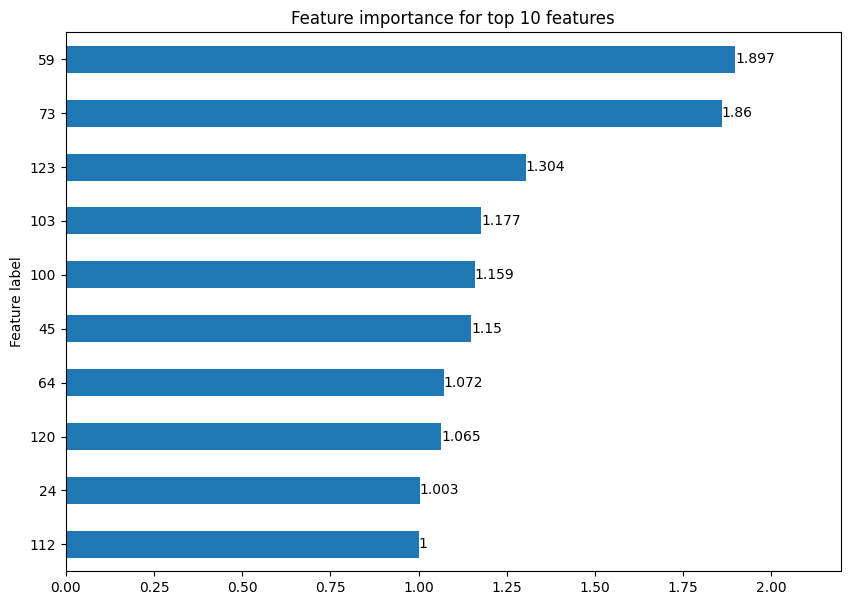

explaining predicted novel drug-disease edges

Explaining edge: Drug: Phenylalanine-free diet -> Disease: Convulsions in the newborn
Predicted probability for edge (Phenylalanine-free diet -> Convulsions in the newborn): 1.0000
Feature importance (top 10 node attributes):


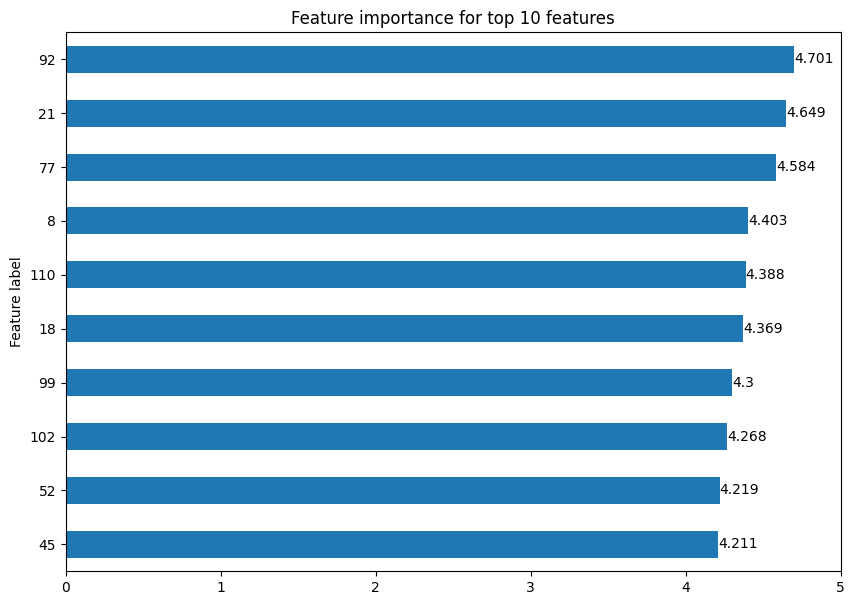

In [39]:
inverted_node_mapping = {mapped: original for original, mapped in node_mapping_fixed.items()}
def get_node_label(mapped_id):
    original_id = inverted_node_mapping.get(mapped_id, None)
    if original_id is None:
        return str(mapped_id)
    return node_label_mapping.get(original_id, str(original_id))

#run GNNExplainer of the selected edge
def explain_drug_disease_edge(src, dst):
    edge_label_index = torch.tensor([[src], [dst]], dtype=torch.long).to(device)

    explanation_edge = explainer(
         x=test_data.x,
         edge_index=test_data.edge_index,
         edge_label_index=edge_label_index,
    )

    #get the predicted probability for the edge
    z = model.encode(test_data.x, test_data.edge_index)
    prob = model.decode(z, edge_label_index).sigmoid().item()
    print(f"Predicted probability for edge ({get_node_label(src)} -> {get_node_label(dst)}): {prob:.4f}")

    print("Feature importance (top 10 node attributes):")
    explanation_edge.visualize_feature_importance(top_k=10)

    return explanation_edge

existing_drug_disease_edges = []
novel_drug_disease_edges = []

for edge in predicted_existing:
    src, dst = edge
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    if (label_src in drugs and label_dst in diseases) or (label_src in diseases and label_dst in drugs):
        existing_drug_disease_edges.append((src, dst))

for edge in predicted_novel:
    src, dst = edge
    label_src = get_node_label(src)
    label_dst = get_node_label(dst)
    if (label_src in drugs and label_dst in diseases) or (label_src in diseases and label_dst in drugs):
        novel_drug_disease_edges.append((src, dst))

print(f"\nNumber of predicted existing drug-disease edges: {len(existing_drug_disease_edges)}")
print(f"Number of predicted novel drug-disease edges: {len(novel_drug_disease_edges)}\n")


print("explaining predicted existing drug-disease edges\n")
for edge in existing_drug_disease_edges[:1]:
    src, dst = edge
    print(f"Explaining edge: Drug: {get_node_label(src)} -> Disease: {get_node_label(dst)}")
    explain_drug_disease_edge(src, dst)

print("explaining predicted novel drug-disease edges\n")
for edge in novel_drug_disease_edges[:1]:
    src, dst = edge
    print(f"Explaining edge: Drug: {get_node_label(src)} -> Disease: {get_node_label(dst)}")
    explain_drug_disease_edge(src, dst)


In [40]:
def visualize_corrected_drug_disease_graph(existing_edges, novel_edges, output_file="selected_drug_disease_graph.html"):
    net = Network(height="100vh",
                  width="100vw",
                  bgcolor="white",
                  font_color="black",
                  cdn_resources="remote")

    net.barnes_hut(gravity=-4000,
                   central_gravity=0.1,
                   spring_length=200,
                   spring_strength=0.005,
                   damping=0.8)


    colors = {
        "existing": "#1f77b4",  #blue - existing
        "novel": "#d62728",  #red - predicted
        "default": "#7f7f7f"
    }

    unique_nodes = set()
    for edge in existing_edges + novel_edges:
        unique_nodes.update(edge)

    for node in unique_nodes:
        label = get_node_label(node)
        net.add_node(node, label=label, title=label, color=colors["default"], size=25)


    for src, dst in existing_edges:
        net.add_edge(src, dst, color=colors["existing"], width=3, title="Existing Drug-Disease Link")

    for src, dst in novel_edges:
        net.add_edge(src, dst, color=colors["novel"], width=3, title="Novel Predicted Drug-Disease Link")

    net.save_graph(output_file)
    return output_file

output_html = visualize_corrected_drug_disease_graph(existing_drug_disease_edges, novel_drug_disease_edges)
output_html


'selected_drug_disease_graph.html'